## License Registration Recognition

In this notebook, we will preprocess the images of license plates and extract the license number from them. We will use the `OpenCV` library and its functions to extract the text from the images.

### Importing Libraries

In [1]:
from scipy.ndimage import *
from scipy.fft import *
from scipy.signal import *
from scipy.stats import *
from skimage.filters import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import *
import skimage.util
from mpl_toolkits import mplot3d
import cv2

Here we define the function for displaying the image and load the necessary images.

In [2]:
def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.show()

In [3]:
from skimage import io

image_1 = io.imread('slike_rega/nonfocused/24799195.jpg')
image_2 = io.imread('slike_rega/nonfocused/24797146.jpg')

### Plate Detection and Extraction

We will use the `CascadeClassifier` to detect the license plate in the image. We will use the `detectMultiScale` function to detect the license plate in the image. We will use the `cv2.rectangle` function to draw the rectangle around the detected license plate.

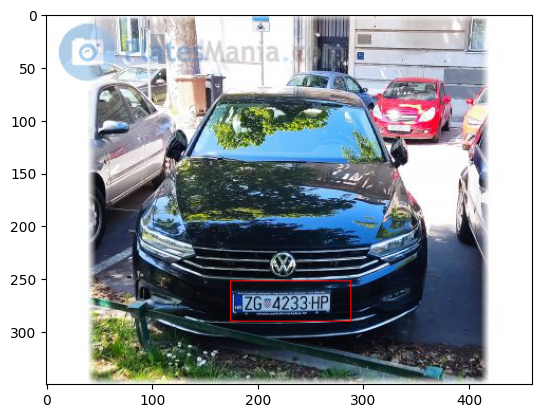

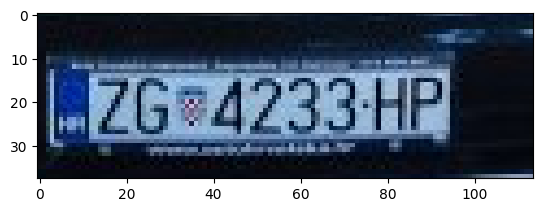

In [86]:
def detect_plate(img):
    plate_cascade = cv2.CascadeClassifier('./cascade/haarcascade_plate_number.xml')
    img_rect = img.copy()
    roi = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plates = plate_cascade.detectMultiScale(gray, 1.1, 4)
    plate_imgs = []
    
    for (x, y, w, h) in plates:
        plate_imgs.append(roi[y:y+h, x:x+w, :])
        cv2.rectangle(img_rect, (x, y), (x+w, y+h), (255, 0, 0), 1)
    return img_rect, plate_imgs

detected_plate, plate_imgs = detect_plate(image_1)
show_img(detected_plate)
show_img(plate_imgs[0])

### Plate Image Enhancment and Segmentation

We will enhance the image quality to help us extract the license plate from the detected region.

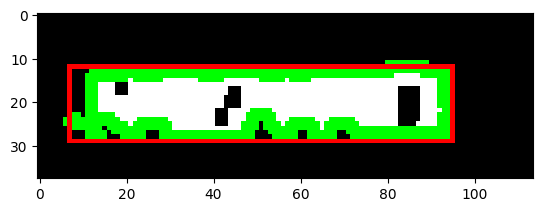

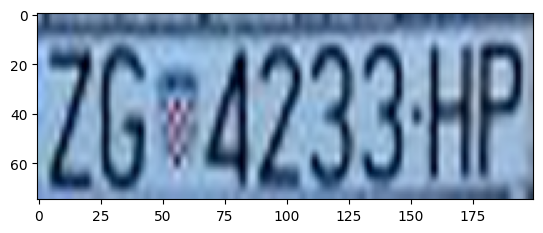

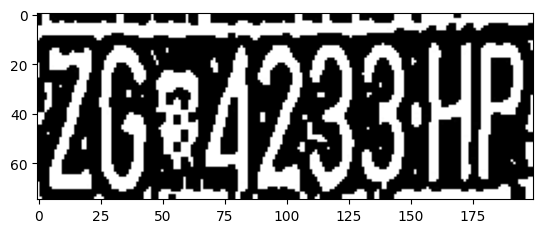

In [87]:
def enhance_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    adaptive_thresh = cv2.adaptiveThreshold(blurred, 255, 
                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            cv2.THRESH_BINARY_INV, 11, 2)
    kernel = np.ones((3, 3), np.uint8)
    morphed = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)
    bilateral_filtered = cv2.bilateralFilter(morphed, 9, 75, 75)
    kernel_sharpening = np.array([[-1, -1, -1], 
                                  [-1,  9, -1],
                                  [-1, -1, -1]])
    sharpened = cv2.filter2D(bilateral_filtered, -1, kernel_sharpening)
    return sharpened

def segment_plate(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.subtract(255, gray)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 128, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour_image = cv2.cvtColor(eroded, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

    # Find the largest contour
    max_contour = max(contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(max_contour)
    cv2.rectangle(contour_image, (x, y), (x+w, y+h), (255, 0, 0), 1)
    plate = image[y:y+h, x+5:x+w]
    show_img(contour_image)
    resized = cv2.resize(plate, (200, 75), interpolation=cv2.INTER_CUBIC)
    return resized

segmented = segment_plate(plate_imgs[0])
show_img(segmented)
sharp = enhance_image(segmented)
show_img(sharp)

### Text Extraction

Here we define the function to extract the text from the image using the `OpenCV` library and its functions.

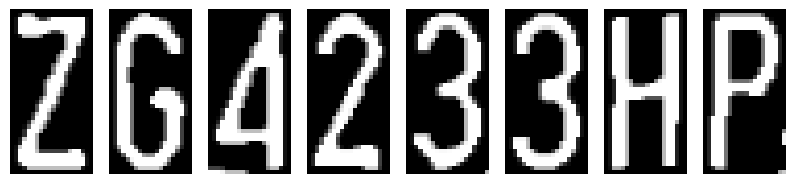

In [88]:
def segment_characters(image):
    blurred = cv2.GaussianBlur(image, (3, 3), cv2.BORDER_DEFAULT)
    _, thresh = cv2.threshold(blurred, 165, 255, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    contour_image = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

    contours = sorted(contours, key=lambda contour: cv2.contourArea(contour), reverse=True)[:10]

    char_list = []
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        if 0.2 < aspect_ratio < 1.0 and h > 40 and h > thresh.shape[0] * 0.5:
            x = max(0, x - 2)
            y = max(0, y - 2)
            w = min(thresh.shape[1] - x, w + 4)
            h = min(thresh.shape[0] - y, h + 4)
            
            char = thresh[y:y + h, x:x + w]
            char = cv2.resize(char, (20, 40))
            char_list.append(char)
            bounding_boxes.append((x, y, w, h))

    char_list = [char for _, char in sorted(zip(bounding_boxes, char_list), key=lambda b: b[0][0])]

    return char_list

char_list = segment_characters(sharp)

fig, axes = plt.subplots(1, len(char_list), figsize=(10, 5))
for i, char in enumerate(char_list):
    axes[i].imshow(char, cmap='gray')
    axes[i].axis('off')
plt.show()